In [107]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import ijson
import seaborn as sns

In [28]:
def compute_speed(timestamps, x_positions, y_positions):
    """
    Computes speed in km/h from position and time data.

    Args:
        timestamps (np.ndarray): Array of timestamps in seconds.
        x_positions (np.ndarray): Array of x positions in meters.
        y_positions (np.ndarray): Array of y positions in meters.

    Returns:
        np.ndarray: Speed in km/h.
    """
    time_diffs = np.diff(timestamps)
    time_diffs[time_diffs == 0] = np.nan  # Avoid division by zero
    
    dx = np.diff(x_positions)
    dy = np.diff(y_positions)
    displacements = np.sqrt(dx**2 + dy**2)  # Euclidean distance

    speeds = displacements / time_diffs  # m/s
    speeds *= 3.6  # Convert to km/h

    return np.insert(speeds, 0, np.nan)  # Align size by inserting NaN at the start

def load_trajectories(file_path, trajectory_timeframe=pd.Timedelta(minutes=10), min_time=None):
    westbound_trajectories = []
    t_min = None
    t_max = None
    MILE_MARKER_61 = 98170  # meters
    # MILE_MARKER_62 = 99779.3  # meters
    MILE_MARKER_62 = 99770  # meters
    # Open file and stream data
    with open(file_path, "r") as f:
        trajectory_iterator = ijson.items(f, "item")
        
        for traj in trajectory_iterator:
            # Mile marker 61 is 322080 feet or 98170 m
            # Mile marker 62 is 327360 feet or 99779.3 m
            x_positions = np.array(traj.get("x_position", []), dtype=np.float32) * 0.3048  # Convert feet to meters
            y_positions = np.array(traj.get("y_position", []), dtype=np.float32) * 0.3048  # Convert feet to meters
            direction = traj.get("direction")

            if len(x_positions) > 1 and direction == -1:
                timestamps = np.array(traj.get("timestamp", []), dtype=np.float64)
                timestamps = pd.to_datetime(timestamps, unit="s").astype(np.int64) / 1e9  # Convert to seconds
                
                if min_time and (timestamps[0] < min_time.timestamp()):
                    continue
                
                westbound_trajectories.append({
                    "trajectory": traj, 
                    "timestamps": timestamps,
                    "x_positions": x_positions,
                    "y_positions": y_positions
                })
                
                # Efficient min/max tracking
                t_min = timestamps[0] if t_min is None else min(t_min, timestamps[0])
                t_max = timestamps[0] if t_max is None else max(t_max, timestamps[0])

                if t_max is not None and t_min is not None and (t_max - t_min) > trajectory_timeframe.total_seconds():
                    break

    print(f"Loaded {len(westbound_trajectories)} westbound trajectories.")

    if not westbound_trajectories:
        return pd.DataFrame(columns=["trajectory_id", "timestamp", "x_position", "speed"])

    # Vectorized DataFrame creation
    all_trajectory_ids = []
    all_timestamps = []
    all_x_positions = []
    all_speeds = []

    # for idx, traj in enumerate(westbound_trajectories):
    #     num_points = len(traj["timestamps"])
    #     all_trajectory_ids.extend([idx] * num_points)
    #     all_timestamps.extend(traj["timestamps"])
    #     all_x_positions.extend(traj["x_positions"])

    #     # Compute speed correctly
    #     # speeds = compute_speed(traj["timestamps"], traj["x_positions"], traj["y_positions"])
    #     # all_speeds.extend(speeds)
    for idx, traj in enumerate(westbound_trajectories):
        mask = (traj["x_positions"] >= MILE_MARKER_61) & (traj["x_positions"] <= MILE_MARKER_62)
        filtered_timestamps = traj["timestamps"][mask]
        filtered_x_positions = traj["x_positions"][mask]
        filtered_y_positions = traj["y_positions"][mask]

        num_points = len(filtered_timestamps)
        all_trajectory_ids.extend([idx] * num_points)
        all_timestamps.extend(filtered_timestamps)
        all_x_positions.extend(filtered_x_positions)
        # all_y_positions.extend(filtered_y_positions)
    df = pd.DataFrame({
        "trajectory_id": np.array(all_trajectory_ids, dtype=np.int32),
        "timestamp": pd.to_datetime(all_timestamps, unit="s"),
        "x_position": np.array(all_x_positions, dtype=np.float32)
        # "speed": np.array(all_speeds, dtype=np.float32)
    })

    print(df.columns.tolist())  # Should include 'trajectory_id'
    print(df)
    
    return df

In [29]:
input_filename = "6386d89efb3ff533c12df167__post10.json"
file_path = os.path.join("/Users/MonicaChan/Desktop/wu-lab/data_tutorial/11-30-2022/", input_filename)
min_t = pd.to_datetime("2022-11-30 13:00:00.400000095")
westbound_trajectories_10_mins_df = load_trajectories(file_path, pd.Timedelta(minutes=10), min_t)

Loaded 28410 westbound trajectories.
['trajectory_id', 'timestamp', 'x_position']
         trajectory_id                     timestamp    x_position
0                   10 2022-11-30 13:00:00.700000048  99314.734375
1                   10 2022-11-30 13:00:00.740000010  99314.250000
2                   10 2022-11-30 13:00:00.780000210  99313.765625
3                   10 2022-11-30 13:00:00.820000172  99313.273438
4                   10 2022-11-30 13:00:00.860000372  99312.789062
...                ...                           ...           ...
2795877          28409 2022-11-30 13:10:02.320000410  99438.804688
2795878          28409 2022-11-30 13:10:02.360000372  99438.484375
2795879          28409 2022-11-30 13:10:02.400000334  99438.179688
2795880          28409 2022-11-30 13:10:02.440000296  99437.875000
2795881          28409 2022-11-30 13:10:02.480000257  99437.570312

[2795882 rows x 3 columns]


In [30]:
# Save westbound trajectories to a csv file
westbound_trajectories_10_mins_df.to_csv("data/westbound_trajectories_10_mins_df.csv")

In [51]:
# Load CSV
westbound_trajectories_10_mins_df = pd.read_csv("data/westbound_trajectories_10_mins_df.csv")
westbound_trajectories_10_mins_df["timestamp"] = pd.to_datetime(westbound_trajectories_10_mins_df["timestamp"])

In [104]:
def get_flow_density_matrix(df, time_interval=pd.Timedelta(minutes=1), space_interval=100, output_filename="output.csv"):
    # Compute min/max for time and space
    t_min, t_max = df["timestamp"].min(), df["timestamp"].max()
    x_min, x_max = df["x_position"].min(), df["x_position"].max()
    
    # Ensure valid ranges
    if x_min == x_max:
        raise ValueError("x_min and x_max are identical, meaning no variation in x_position.")
    
    # Create time and space bins
    time_bins = pd.date_range(start=t_min, end=t_max, freq=time_interval)
    space_bins = np.arange(x_min, x_max + space_interval, space_interval)
    
    if len(space_bins) < 2:
        raise ValueError("space_bins array is empty or too small, adjust space_interval.")
    
    # Assign bin indices using `pd.cut()`
    df["time_bin"] = pd.cut(df["timestamp"], bins=time_bins, labels=False, include_lowest=True)
    df["space_bin"] = pd.cut(df["x_position"], bins=space_bins, labels=False, include_lowest=True)

    # Remove NaNs (out-of-range values)
    df = df.dropna(subset=["time_bin", "space_bin"]).astype({"time_bin": int, "space_bin": int})

    # Compute flow and density using `groupby()`
    flow_matrix = np.zeros((len(time_bins) - 1, len(space_bins) - 1))
    density_matrix = np.zeros_like(flow_matrix)

    grouped = df.groupby(["time_bin", "space_bin"])
    area_bin = (space_interval/1000.) * time_interval.total_seconds() / 3600.0 #convert space interval to kilometers, time_interval to hours
    done = False
    for (time_bin, space_bin), group in grouped:
        traj_group = group.groupby("trajectory_id")
        traj_dict = {traj_id: traj_data for traj_id, traj_data in traj_group}
        if not done:
            plt.figure(figsize=(8, 5))
            
            for traj_id, traj_data in traj_dict.items():
                dist_traveled = (traj_data["x_position"].max()-traj_data["x_position"].min())/1000
                time_traveled = (traj_data["timestamp"].max()-traj_data["timestamp"].min()).total_seconds()/3600
                print(dist_traveled/time_traveled)
                plt.plot(traj_data["timestamp"], traj_data["x_position"], marker='o', linestyle='-', linewidth=0.4, markersize=1,label=f'Traj {traj_id}')
            
            plt.xlabel("Timestamp")
            plt.ylabel("X Position")
            plt.title(f"Trajectories in First Bin (Time Bin: {time_bin}, Space Bin: {space_bin})")
            plt.xticks(rotation=45)
            # plt.legend()
            plt.grid(True)
            plt.show()
        total_distance = sum(traj_group["x_position"].apply(lambda x: x.max()-x.min()))
        total_time = sum(traj_group["timestamp"].apply(lambda x: (x.max() - x.min()).total_seconds()))
        
        # print("time", total_time)
        flow_matrix[time_bin, space_bin] = (total_distance / 1000.) / area_bin
        density_matrix[time_bin, space_bin] = (total_time / 3600.0) / area_bin
        if not done:
            done = True
            print("flow calculated", (total_distance / 1000.) / area_bin)
            print("density calculated", (total_time / 3600.0) / area_bin)
    print(grouped)
    
    full_filepath = "data/" + output_filename
    form_csv(flow_matrix, density_matrix, time_interval, space_interval, t_min, t_max, x_min, x_max, full_filepath)
    return flow_matrix, density_matrix

In [57]:
def form_csv(flow_matrix, density_matrix, time_increment, space_increment, t_min, t_max, x_min, x_max, output_filename="output.csv"):
    num_time_bins, num_space_bins = flow_matrix.shape
    
    time_values = np.array([t_min + i * time_increment for i in range(num_time_bins)])
    space_values = np.array([x_min + i * space_increment for i in range(num_space_bins)])
    
    time_grid, space_grid = np.meshgrid(time_values, space_values, indexing='ij')
    
    df = pd.DataFrame({
        "Time": time_grid.ravel(),
        "Space": space_grid.ravel(),
        "Flow": flow_matrix.ravel(),
        "Density": density_matrix.ravel()
    })
    
    df.to_csv(output_filename, index=False)
    
    print(f"CSV file saved as {output_filename}")


In [131]:
def plot_matrices(flow_matrix, density_matrix, time_increment, space_increment, t_min, t_max, x_min, x_max):

    plt.figure(figsize=(12, 12))

    # Compute reasonable tick marks
    num_time_bins = flow_matrix.shape[0]
    num_space_bins = flow_matrix.shape[1]

    time_ticks = np.linspace(0, num_time_bins - 1, min(10, num_time_bins)).astype(int)
    space_ticks = np.linspace(0, num_space_bins - 1, min(10, num_space_bins)).astype(int)

    time_labels = [(t_min + i * time_increment).strftime("%H:%M") for i in time_ticks]
    space_labels = [int(x_min + i * space_increment) for i in space_ticks]

    # Create heatmap for flow matrix
    ax1 = plt.subplot(2, 2, 1)
    sns.heatmap(flow_matrix.T, cmap="YlGnBu", xticklabels=time_labels, yticklabels=space_labels[::-1], cbar_kws={'label': 'Flow (veh/hr)'})
    plt.title(f"Time-Space Diagram of Vehicle Flow\n{time_increment} time increments, {space_increment} meters")
    plt.xlabel("Time")
    plt.ylabel("Space (meters)")
    plt.xticks(time_ticks, time_labels, rotation=45)
    plt.yticks(space_ticks, space_labels)
    # ax1.invert_yaxis()  # Reverse the y-axis

    # Plot the speed matrix
    ax2 = plt.subplot(2, 2, 2)
    sns.heatmap(density_matrix.T, cmap="RdYlGn",xticklabels=time_labels, yticklabels=space_labels[::-1], cbar_kws={'label': 'Average Density (veh/km)'})
    plt.title(f"Time-Space Diagram of Vehicle Density\n{time_increment} time increments, {space_increment} meters")
    plt.xlabel("Time")
    plt.ylabel("Space (meters)")
    plt.xticks(time_ticks, time_labels, rotation=45)
    plt.yticks(space_ticks, space_labels)
    # ax2.invert_yaxis()  # Reverse the y-axis

    ax3 = plt.subplot(2,2, 3)
    sns.heatmap(flow_matrix.T/density_matrix.T, cmap="RdYlGn",xticklabels=time_labels, yticklabels=space_labels[::-1], cbar_kws={'label': 'Speed (km/h)'})
    plt.title(f"Time-Space Diagram of Vehicle Speed\n{time_increment} time increments, {space_increment} meters")
    plt.xlabel("Time")
    plt.ylabel("Space (meters)")
    plt.xticks(time_ticks, time_labels, rotation=45)
    plt.yticks(space_ticks, space_labels)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

93.46406250000655
81.02312886098139
92.27783505154802
82.21204567335825
81.18818181817846
69.44516129031751
58.38236248077819
83.37198209625357
68.44465648854961
90.69430885059681
72.60299999995914
64.05196884804523
88.96633663367322
60.83878585693352
63.586956521739125
85.10627045823911
71.65079999999958
66.13014705882853
83.26263627630905
71.0857283900284
67.97213114754055
63.945011418752784
55.15724135222792
84.11603773585499
76.33867924527362
68.1320740710053
56.16351554181164
59.71398820580466
71.46719999999623
80.25267857143652
47.42166666666889
75.87692307692264
81.35590909090718
65.3783823529471
65.3978221528796
82.93459881649996
76.6769230769289
68.37906976743821
77.77566908167083
76.06153846154204
80.14864864865336
74.07796841101934
73.19250000006286
71.04467213114239
64.69239130435238
81.62754165769353
67.57297297297013
71.48879999999538
70.3488888888872
65.05621625113359
81.84220183487055
81.2536548303742
59.57400000000489
78.47370141966675
79.59374999999064
60.603071531134

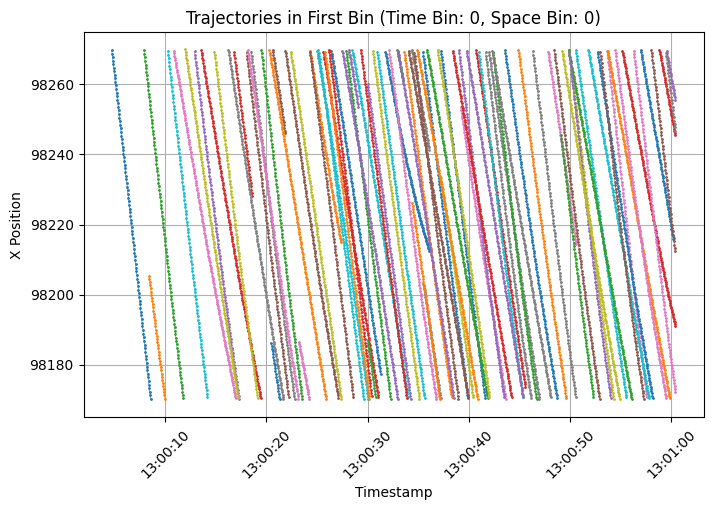

flow calculated 4414.676400000031
density calculated 61.219993500000015
CSV file saved as data/1min_100_m_flow_speed.csv


In [105]:
# 100m, 1 minute
flow_1min_100m, density_1min_100m = get_flow_density_matrix(westbound_trajectories_10_mins_df, time_interval = pd.Timedelta(minutes=1), space_interval = 100, output_filename="1min_100_m_flow_speed.csv")

# 100m, 10 sec
# flow_10sec_100m, density_10sec_100m = get_flow_density_matrix(westbound_trajectories_10_mins_df, time_interval = pd.Timedelta(seconds=10), space_interval = 100, output_filename="10sec_100_m_flow_speed.csv")


ValueError: num must be an integer with 1 <= num <= 2, not 3

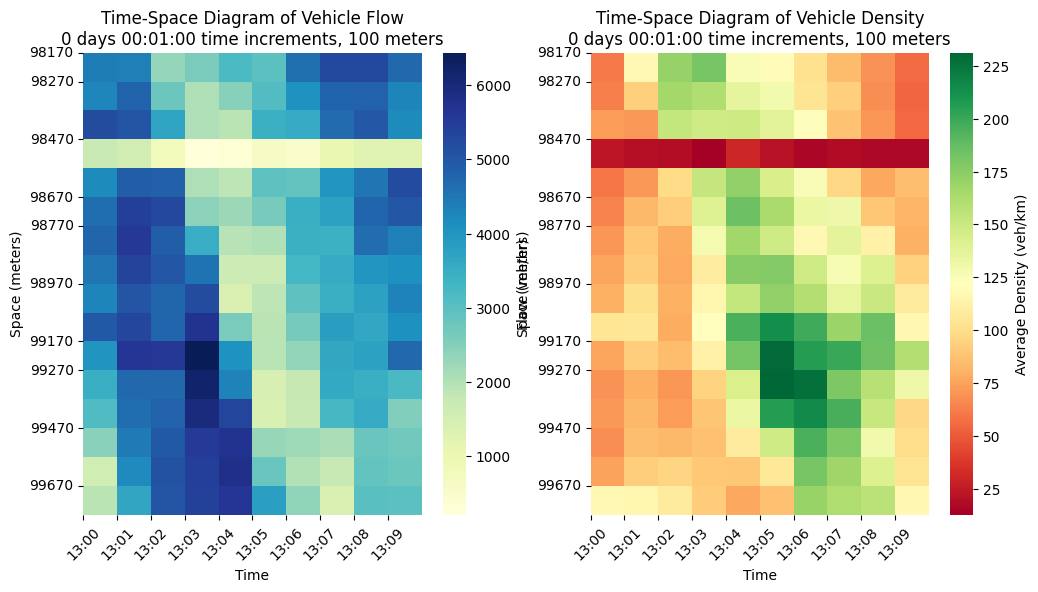

In [123]:
t_min, t_max = westbound_trajectories_10_mins_df["timestamp"].min(), westbound_trajectories_10_mins_df["timestamp"].max()
x_min, x_max = westbound_trajectories_10_mins_df["x_position"].min(), westbound_trajectories_10_mins_df["x_position"].max()
plot_matrices(flow_1min_100m, density_1min_100m, pd.Timedelta(minutes=1), 100, t_min, t_max, x_min, x_max)
plot_matrices(flow_10sec_100m, density_10sec_100m, pd.Timedelta(seconds=10), 100,  t_min, t_max, x_min, x_max)

In [108]:
input_filename = "6386d89efb3ff533c12df167__post10.json"
min_t = pd.to_datetime("2022-11-30 14:00:00.400000095")

file_path = os.path.join("/Users/MonicaChan/Desktop/wu-lab/data_tutorial/11-30-2022/", input_filename)
westbound_trajectories_1_hr_df = load_trajectories(file_path, pd.Timedelta(hours=1), min_t)

Loaded 150088 westbound trajectories.
['trajectory_id', 'timestamp', 'x_position']
          trajectory_id                     timestamp    x_position
0                     2 2022-11-30 14:00:01.200000048  99587.476562
1                     2 2022-11-30 14:00:01.240000010  99587.390625
2                     2 2022-11-30 14:00:01.280000210  99587.304688
3                     2 2022-11-30 14:00:01.320000172  99587.218750
4                     2 2022-11-30 14:00:01.360000372  99587.140625
...                 ...                           ...           ...
13981092         150074 2022-11-30 15:00:00.720000267  98579.281250
13981093         150074 2022-11-30 15:00:00.760000467  98578.125000
13981094         150074 2022-11-30 15:00:00.800000429  98576.960938
13981095         150074 2022-11-30 15:00:00.840000629  98575.796875
13981096         150074 2022-11-30 15:00:00.880000353  98574.632812

[13981097 rows x 3 columns]


In [109]:
# Save to csv
westbound_trajectories_1_hr_df.to_csv("data/westbound_trajectories_1_hr_df.csv")


In [110]:
# load CSV
westbound_trajectories_1_hr_df = pd.read_csv("data/westbound_trajectories_1_hr_df.csv")

In [111]:
westbound_trajectories_1_hr_df["timestamp"] = pd.to_datetime(westbound_trajectories_1_hr_df["timestamp"])

1.4813666896499589
6.434288267575873
21.631764705882663
5.243132530118293
28.098316990809618
11.699999999982538
27.321428571428577
18.880166589545315
0.07922535211267606
33.56470588233445
27.519233709320964
3.667164374582434
24.918974794366136
0.11250000000291038
0.11275862068628313
153.5621726150014
0.14516129032258066
1.1999999999950108
27.684000000000324
28.511999999993712
22.457692307692085
27.841488223024918
6.197571428575819
23.816339522548837
21.156459330145548
13.409177387418316
27.531833824918674
27.3936469932741
40.11923076921868
37.36799999999057
29.715174418606907
30.207272727272215
29.449837948179187
42.74765624999645
43.15500000001048
21.30495867768783
42.73200000000943
45.843893262133705
31.234854771784015
29.03009943609168
34.23778625954139
60.221476510065365
43.31554054052921
44.460901052351815
19.51513761468058
36.704511957432935
47.4191818457089
41.56667147762183
47.75333333332674
48.48506093547023
40.51628959276232
49.992352941172776
52.929593628637804
41.2811385662

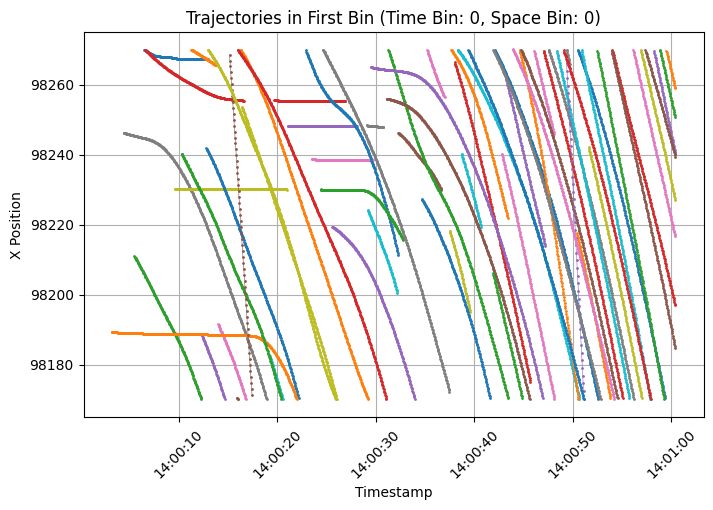

flow calculated 2257.955400000003
density calculated 78.03999533333332
CSV file saved as data/1min_100_m_flow_speed_1hr.csv


In [112]:
flow_1min_100m_1hr, density_1min_100m_1hr = get_flow_density_matrix(westbound_trajectories_1_hr_df, time_interval = pd.Timedelta(minutes=1), space_interval = 100, output_filename="1min_100_m_flow_speed_1hr.csv")


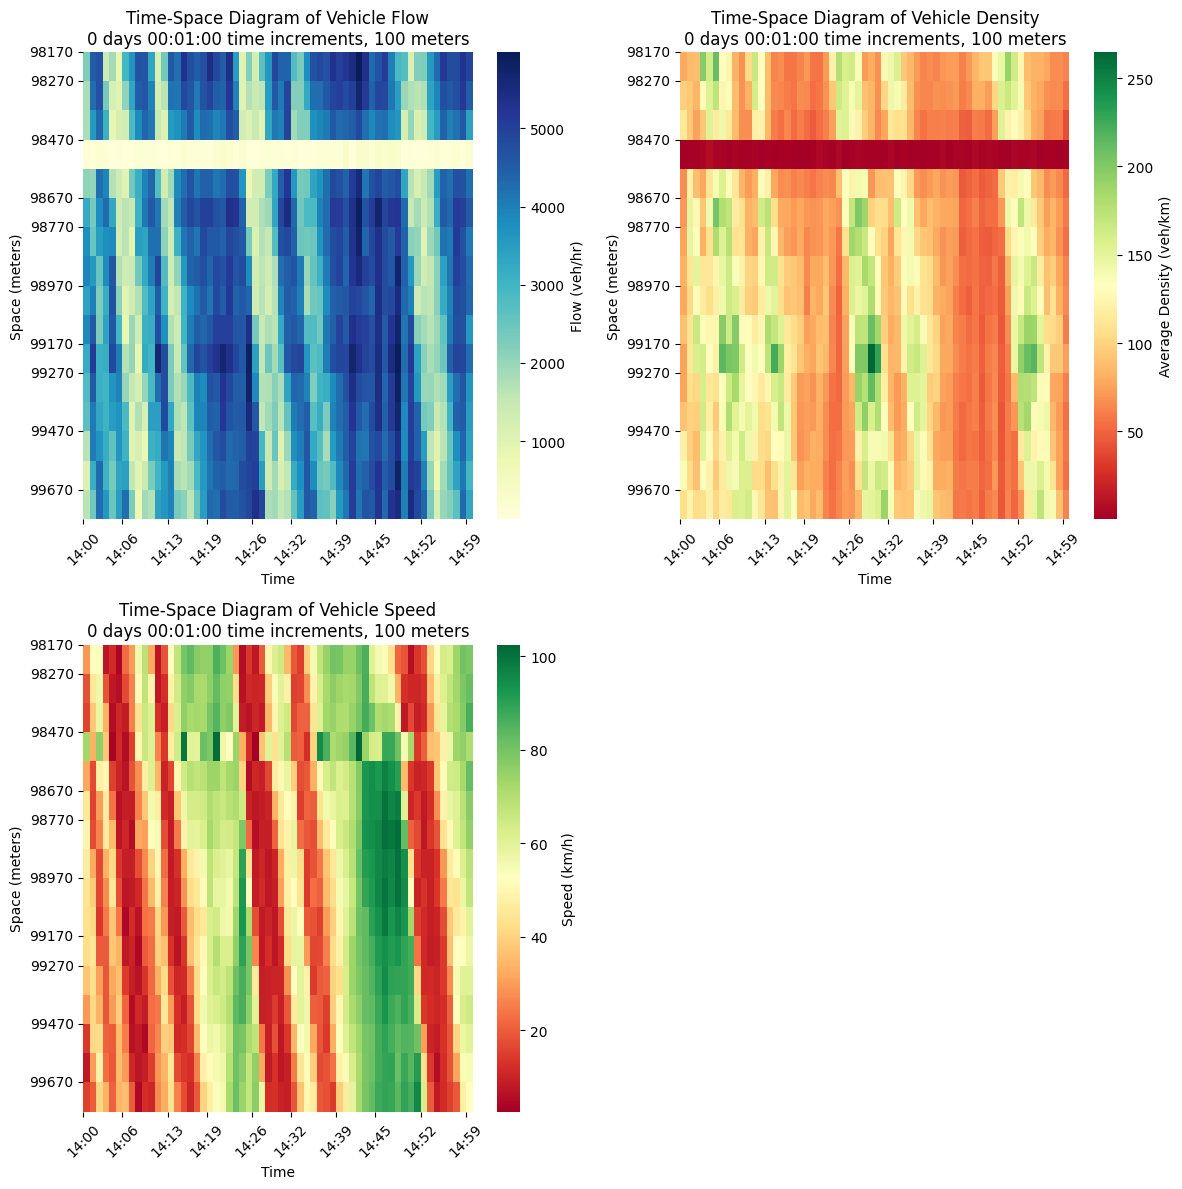

In [132]:
t_min, t_max = westbound_trajectories_1_hr_df["timestamp"].min(), westbound_trajectories_1_hr_df["timestamp"].max()
x_min, x_max = westbound_trajectories_1_hr_df["x_position"].min(), westbound_trajectories_1_hr_df["x_position"].max()
plot_matrices(flow_1min_100m_1hr, density_1min_100m_1hr, pd.Timedelta(minutes=1), 100, t_min, t_max, x_min, x_max)


2.475000644530872
19.69672131147326
8.01383191856786
7.116000000000349
0.5921052631578948
0.3250000000043656
19.575244691108704


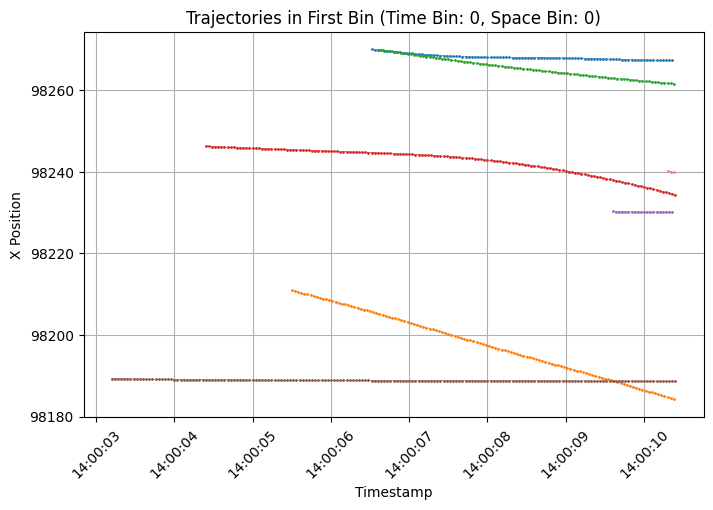

flow calculated 182.8080000000482
density calculated 26.519997000000004
CSV file saved as data/10sec_100_m_flow_speed_1hr.csv


In [114]:
flow_10sec_100m_1hr, speed_10sec_100m_1hr = get_flow_density_matrix(westbound_trajectories_1_hr_df, time_interval = pd.Timedelta(seconds=10), space_interval = 100, output_filename="10sec_100_m_flow_speed_1hr.csv")


/var/folders/62/xsv7fswn07v3g_tnkw68s6lh0000gn/T/ipykernel_37116/3785174750.py:36: RuntimeWarning: invalid value encountered in divide
  sns.heatmap(flow_matrix.T/density_matrix.T, cmap="RdYlGn",xticklabels=time_labels, yticklabels=space_labels[::-1], cbar_kws={'label': 'Speed (km/h)'})


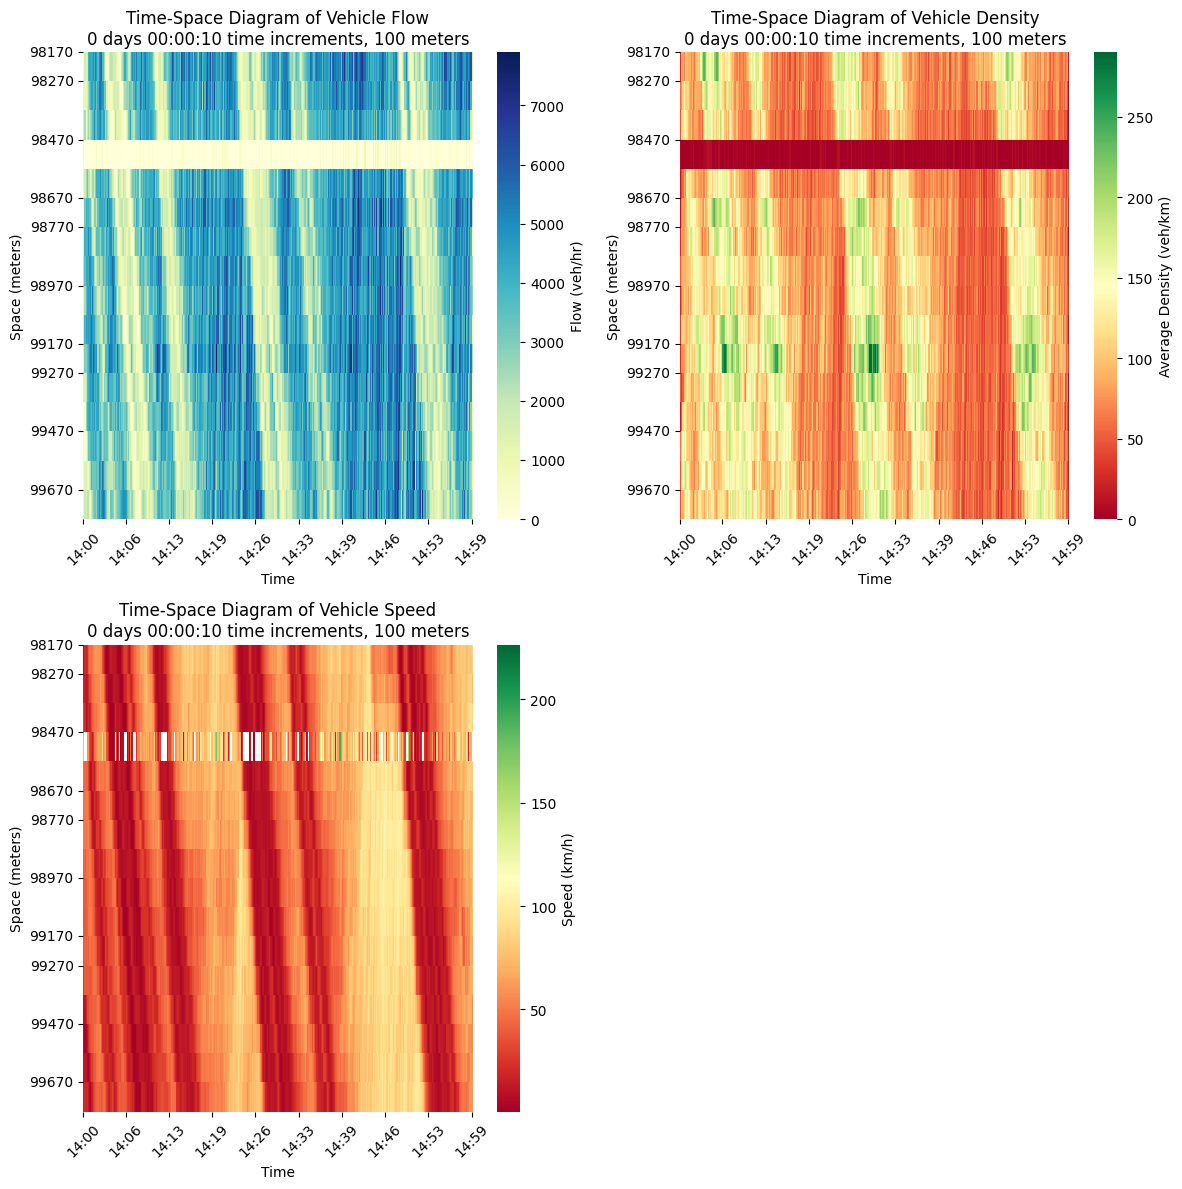

In [133]:
plot_matrices(flow_10sec_100m_1hr, speed_10sec_100m_1hr, pd.Timedelta(seconds=10), 100,  t_min, t_max, x_min, x_max)

25.8619354838757
16.014132610618404
9.03374999999869
2.1443478260896325
9.2451063829785
21.631764705882663
10.043333333334886
10.647906976742508
28.098316990809618
11.08298969072813
11.699999999982538
27.321428571428577
17.96931818182533
18.880166589545315
31.12200000001467
10.391150442481583
0.07922535211267606
0.7042105263099074
12.632846715325789
33.56470588233445
27.519233709320964
1.9630437153431908
3.667164374582434
0.23365395847841305
12.300967741938356
24.918974794366136
0.428571428565192
0.11250000000291038
0.11275862068628313
148.89003101875952
0.14516129032258066
1.1999999999950108
24.4664706278089
26.28482142857657
0.1898437500130967
28.511999999993712
23.66966292134871
23.593846153845348
6.197571428575819
10.53961165048503
7.049477351915098
9.651552694210466
6.170021052631292
17.841540577717872
21.156459330145548
6.750084375792763
13.409177387418316
16.97193675889556
27.861702127665147
28.564936031711312
18.743938029464044
24.78316441662552
1.4086956521761906
40.1192307692

/var/folders/62/xsv7fswn07v3g_tnkw68s6lh0000gn/T/ipykernel_37116/4289293830.py:40: RuntimeWarning: invalid value encountered in scalar divide
  print(dist_traveled/time_traveled)


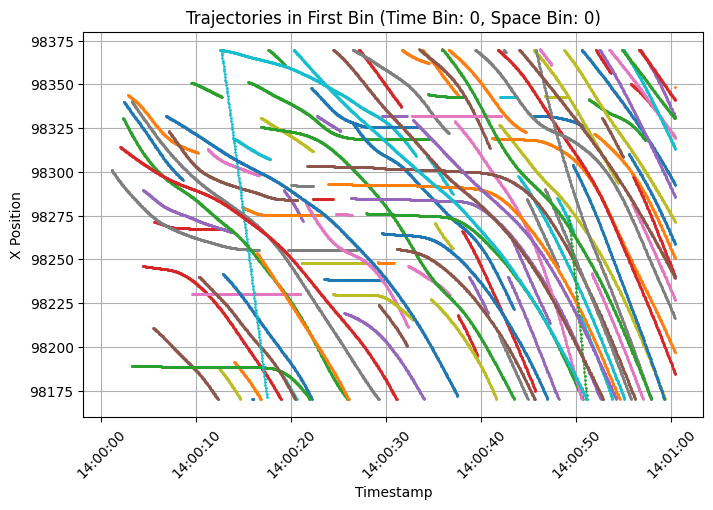

flow calculated 2024.1978000000393
density calculated 88.35333083333333
CSV file saved as data/1min_200_m_flow_speed_1hr.csv


In [116]:
flow_1min_200m_1hr, density_1min_200m_1hr = get_flow_density_matrix(westbound_trajectories_1_hr_df, time_interval = pd.Timedelta(minutes=1), space_interval = 200, output_filename="1min_200_m_flow_speed_1hr.csv")


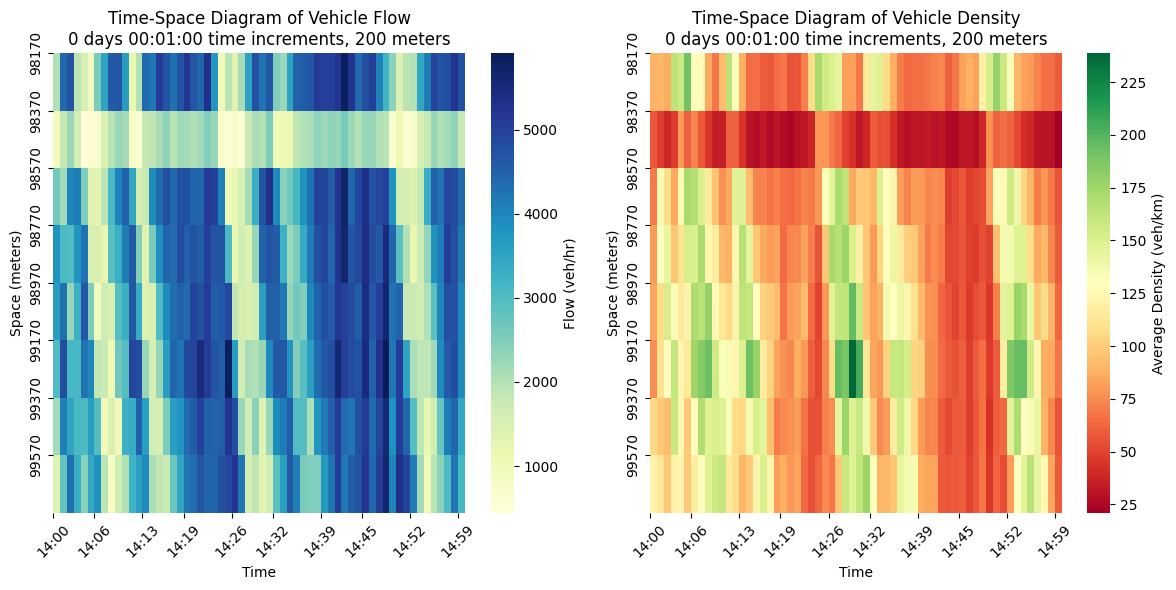

In [117]:
plot_matrices(flow_1min_200m_1hr, density_1min_200m_1hr, pd.Timedelta(minutes=1), 200,  t_min, t_max, x_min, x_max)

1.4813666896499589
6.434288267575873
21.631764705882663
5.243132530118293
28.098316990809618
11.699999999982538
27.321428571428577
18.880166589545315
0.07922535211267606
33.56470588233445
27.519233709320964
3.667164374582434
24.918974794366136
0.11250000000291038
0.11275862068628313
153.5621726150014
0.14516129032258066
1.1999999999950108
27.684000000000324
28.511999999993712
22.457692307692085
27.841488223024918
6.197571428575819
23.816339522548837
21.156459330145548
13.409177387418316
27.531833824918674
27.3936469932741
40.11923076921868
37.36799999999057
29.715174418606907
30.207272727272215
29.449837948179187
42.74765624999645
43.15500000001048
21.30495867768783
42.73200000000943
45.843893262133705
31.234854771784015
29.03009943609168
34.23778625954139
60.221476510065365
43.31554054052921
44.460901052351815
19.51513761468058
36.704511957432935
47.4191818457089
41.56667147762183
47.75333333332674
48.48506093547023
40.51628959276232
49.992352941172776
52.929593628637804
41.2811385662

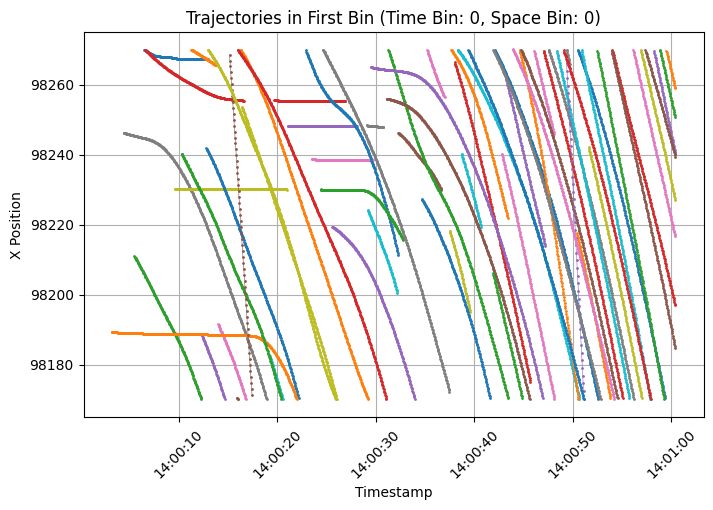

flow calculated 2257.955400000003
density calculated 78.03999533333332
CSV file saved as data/1min_100_m_flow_speed_1hr.csv


In [118]:
flow_1min_100m_1hr, density_1min_100m_1hr = get_flow_density_matrix(westbound_trajectories_1_hr_df, time_interval = pd.Timedelta(minutes=1), space_interval = 100, output_filename="1min_100_m_flow_speed_1hr.csv")


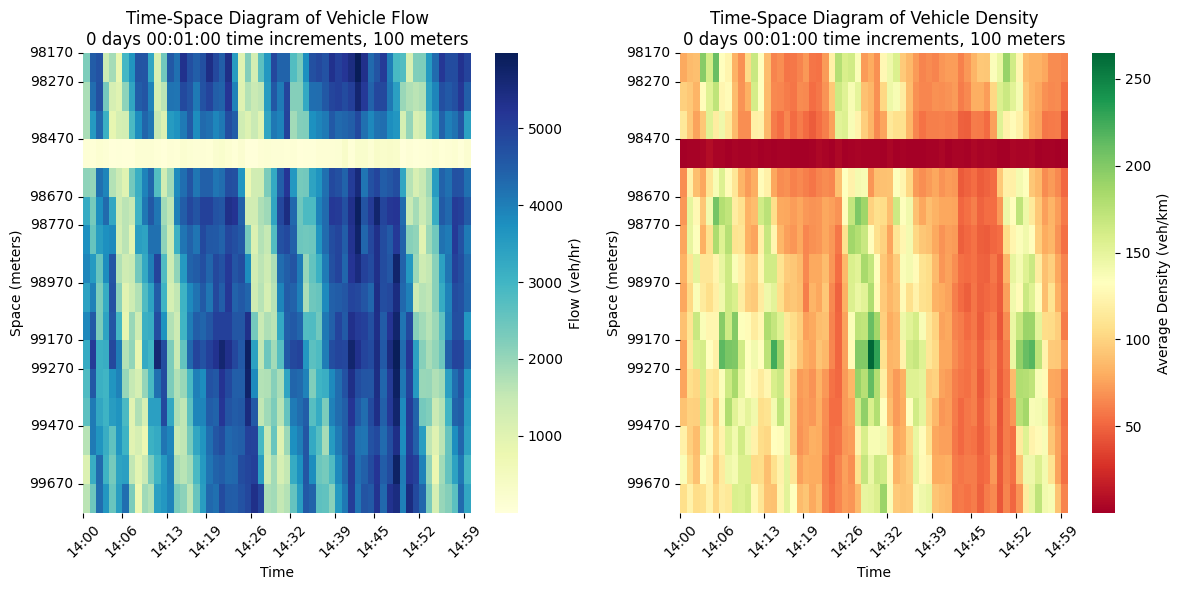

In [119]:
plot_matrices(flow_1min_100m_1hr, density_1min_100m_1hr, pd.Timedelta(minutes=1), 100,  t_min, t_max, x_min, x_max)